In [2]:
import matplotlib
%matplotlib inline

GENERAL DESCRIPTION:
Capturing cultural diffusion by converting each cuisine to a TF-IDF vector (based on its ingredients), using PCA to obtain two vectors for visualization purposes, and clustering them by K-Means. There are several improvements that one could easily think of, but the basic results prove to be quite good - Asia for example is separate from the rest and notice how the 'filipino' cuisine is also slightly separate from the rest of Asia (it is known to be quite different from the other Asian cuisines).

D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


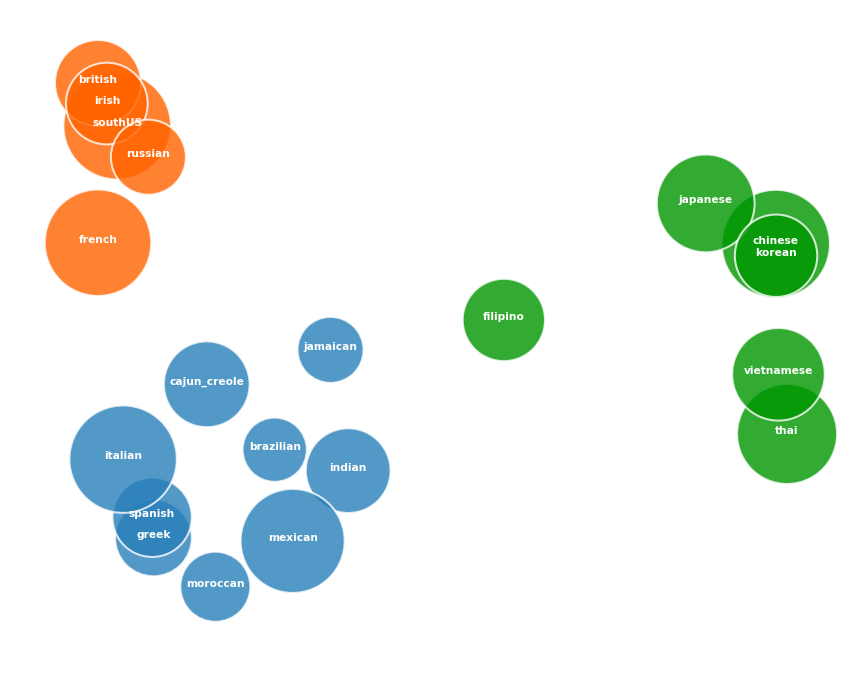

In [3]:
# loading the data
##################
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfTransformer

with open('./data/train.json') as data_file:    
    data = json.load(data_file)

##################################################################
# SECTION 1: From JSON to a countsMatrix 
# countsMatrix is a matrix where the [i,j] cell is the number of 
# times ingredient j appears in cuisine i (total number of appearances
# over all recipes for that cuisine). This is a preliminary 
# step required for running tf-idf. 
##################################################################


# This function creates a dictionary of ingredients per
# cuisine (takes all ingredients from all recipes for that
# cuisine to create one large vector. At this stage ingredients 
# can appear more than once per cuisine as this will be used
# to create the tf-idf matrix later on).
##################################################################
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
        
        # just changing the name of one of the cuisines so
        # it is more readable in the final visualization
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'southUS'

        ingredientsPerCuisine = json[i]['ingredients']
        
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients


# This function prepares the data for tf-idf (before 
# running the tf-idf function you need to supply it
# with a a term-count matrix where rows (i) are cuisines, columns (j) are 
# ingredients and the value in cell [i,j] is the number of times
# the j'th ingredient appeared in the i'th cuisine.
##################################################################
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #in order to know which column to put the term count in, we will ago according to the terms' order in the ingredients array
            termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix
    

dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)
            

##################################################################
# SECTION 2: tf-idf + pca 
# This section creates 'reduced_data' which is the countsMatrix 
# above AFTER PCA where we took only the first two principal components
##################################################################

import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')

# This function creates the tf-idf matrix using a countsMatrix. 
# This creates a similar matrix to the one above, but this time
# the [i,j] cell is the tf-idf weight of ingredient j in
# cuisine i (instead of the counts)
##################################################################
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

# creating the tf-idf matrix
###########################################
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)


# running PCA to reduce to 2 dimensions
###########################################
pca = PCA(n_components=2)
# print(pca.explained_variance_ratio_)   
reduced_data = pca.fit_transform(tfIdf_Matrix)

# converting to pandas dataframe for convenience:
###########################################
pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2']


##################################################################
# SECTION 3: KMEANS
##################################################################

from sklearn.cluster import KMeans

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(3)


##################################################################
# SECTION 4: SIZE OF BUBBLES
# JACCARD SIMILARITY (one vs the other cuisines in its cluster)
# We intersect all ingredients of cuisine i with the union of 
# ingredients in all OTHER cuisines in its CLUSTER! (e.g.:
# intersect(filipino_Ingredients, other_asian_Ingredients)
# and divide by the union of all ingredients in the cluster.
##################################################################

i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1


##################################################################
# SECTION 5: RUNNING THE FINAL PLOT WITH SIZE = JACCARD SIM.
# The size of the bubble is determined by the within-cluster 
# similarity which is obtained by the Jaccard similarity of each 
# cuisine with other members in it its cluster (computed above).
##################################################################

from pylab import *
from scipy import *
import matplotlib.pyplot as plt

rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show()